# MarketLogic data science coding project

The file pdfs.tar.bz2 contains 8548 pdf files. Each pdf consists of a sentence (with scrambled
characters) and the class to which the sentence belongs. All files a formatted like the example
below.

class: 1

text: Gur onyy ebyyrq qbja gur uvyy.

The first line describes the class of the sentence. Where "1" means the sentence is grammatically
correct and proper English (also the characters are scrambled) and a "0" means the opposite.


## Task 1
Implement a parser that parses the pdfs and extracts the class variables as well as the sentences.
You may want to store the class variables and sentences in a data format of your choice or use
them directly for Task 2

## Task 2
Implement a classifier that classifies sentences into either of the two classes. 
There are no restriction on the technology you use. 
To evaluate the classifier your code should report precision,
recall, F1 score. 
Also show how good your classifier generalizes by testing it with unseen data.

## Task 3
Implement an algorithm to unscramble the characters so sentences can be read in plain English.
Submission
Submit all your code + an instruction how to use it. Please also prepare and submit an illustrative
summary about the project and its results.

## Submission
Submit all your code + an instruction how to use it. Please also prepare and submit an illustrative
summary about the project and its results.


In [1]:
#!pip install PyPDF2

     |████████████████████████████████| 81kB 1.8MB/s eta 0:00:011
  Stored in directory: /Users/kai/Library/Caches/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [13]:
#!pip install pdfminer.six

     |████████████████████████████████| 5.6MB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 4.8MB/s eta 0:00:01


In [213]:
import collections
from collections import Counter

import pickle

import sys, os, re, csv, codecs, math, logging, base64

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats, interp
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.misc import imread

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.utils.fixes import signature
 

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from tqdm import tqdm

import keras
from keras.utils import np_utils
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

#stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory


from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

np.random.seed(42)


[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- ## Task 1

Implement a parser that parses the pdfs and extracts the class variables as well as the sentences.

In [216]:
def convert_pdf_to_txt(path):
    """
    This function takes a pdf path as input and outputs the text in the pdf file.
    """
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    
    return text

In [215]:
# test the function
text = convert_pdf_to_txt("../pdfs/0A9Hhx9f3hLSXUHwtrQq7eVJR9AnkcuB.pdf")
print(text)

class: 0
text: Gur unaqyr qrgnpurq sebz gur obk.

1




In [217]:
def get_class_text(pdf_text):
    """
    This function takes the text from the pdf as input and outputs 'class' and 'text'.
    """
    class_label = -1
    text = ''
    str_list = pdf_text.splitlines()
    for str_el in str_list:
        if 'class' in str_el:
            class_label = int(str_el.split(':')[1].strip())
        elif 'text' in str_el:
            text = str_el.split(':')[1].strip()
    return class_label, text           

In [220]:
# test the function
text = convert_pdf_to_txt("../pdfs/0A9Hhx9f3hLSXUHwtrQq7eVJR9AnkcuB.pdf")
print(text)

class_label, text = get_class_text(pdf_text)
print('class: {} text: {}'.format(class_label, text))

class: 0
text: Gur unaqyr qrgnpurq sebz gur obk.

1


class: 0 text: Gur unaqyr qrgnpurq sebz gur obk.


In [221]:
def get_file_list(dir_path, extention='.pdf'):
    """
    This function returns all the pdf file paths in a given folder.
    """
    file_list = []
    for file in os.listdir(dir_path):
        if file.endswith(extention):
            file_list.append(os.path.join(dir_path, file))
    return file_list

In [222]:
def get_df_pdf(pdf_dir='../pdfs/'):
    """
    This function takes a folder path as input and outputs a pandas dataframe.
    The dataframe contains all the classes and the text.
    """
    dict_pdf = {'class':[], 'text':[]}
    
    file_list = get_file_list(pdf_dir)
    
    for file_path in file_list:
        pdf_text = convert_pdf_to_txt(file_path)
        class_label, text = get_class_text(pdf_text)
        dict_pdf['class'].append(class_label)
        dict_pdf['text'].append(text)
    
    df_pdf = pd.DataFrame(dict_pdf)
    return df_pdf

In [223]:
df_pdf = get_df_pdf()
df_pdf.head()

,class,text
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.


- Save the dataframe to a pickle file

In [224]:
df_pdf.to_pickle("./df_pdf.pkl")

In [225]:
df_pdf = pd.read_pickle("./df_pdf.pkl")

In [226]:
df_pdf.head()

,class,text
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.


- ### How to use the pdf parser

In [315]:
# pdf_folder = "./df_pdf.pkl"
# df_pdf = get_df_pdf(pdf_folder)

- ## Task 2

Implement a classifier that classifies sentences into either of the two classes. 

In [227]:
def f(my_str):
    """
    This function removes the punctuation from a given string.
    """
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

In [228]:
# remove the punctuation in 'text'.
df_pdf['text_non_pun'] = df_pdf['text'].apply(f)

In [229]:
df_pdf.head()

,class,text,text_non_pun
0,1,Gur pubpbyngr zrygrq bagb gur pnecrg.,Gur pubpbyngr zrygrq bagb gur pnecrg
1,1,Jnf ur oryvrirq rire gb snvy fghqragf?,Jnf ur oryvrirq rire gb snvy fghqragf
2,1,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...,Fgrcura oryvrirq gurer gb or n sbhagnva va gur...
3,1,Gung xvaq bs orunivbe naablf zr.,Gung xvaq bs orunivbe naablf zr
4,1,Enl sbhaq gur bhgpbzr sehfgengvat.,Enl sbhaq gur bhgpbzr sehfgengvat


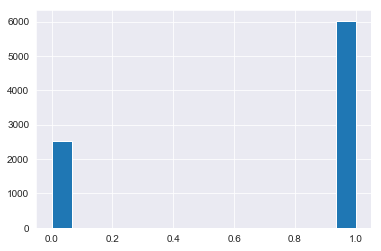

In [317]:
plt.hist(df_pdf['class'].tolist(), bins='auto')  
plt.show()

It shows that the data is imbalanced. It would make the binary classification task difficult.

- ### Define evaluation metric

- #### Logloss

For a binary classification like this task, the typical loss function is the binary cross-entropy / log loss.

$$H_p(q) = - \frac{1}{N} \sum_{i=1}^{N} y_i \times log(p(y_i)) + (1-y_i) \times log(1-p(y_i))$$

Neural networks are trained using stochastic gradient descent and require that you choose a loss function when designing and configuring your model.

Given input, the model is trying to make predictions that match the data distribution of the target variable. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

**Cross-Entropy Loss** (or Log Loss)

Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or “log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average cross entropy across all examples.

Given a framework of maximum likelihood, we know that we want to use a cross-entropy or mean squared error loss function under stochastic gradient descent.

Nevertheless, we may or may not want to report the performance of the model using the loss function.

For example, logarithmic loss is challenging to interpret, especially for non-machine learning practitioner stakeholders. The same can be said for the mean squared error. Instead, it may be more important to report the accuracy and root mean squared error for models used for classification and regression respectively.

It may also be desirable to choose models based on these metrics instead of loss. This is an important consideration, as the model with the minimum loss may not be the model with best metric that is important to project stakeholders.

A good division to consider is to use the loss to evaluate and diagnose how well the model is learning. This includes all of the considerations of the optimization process, such as overfitting, underfitting, and convergence. An alternate metric can then be chosen that has meaning to the project stakeholders to both evaluate model performance and perform model selection.

The same metric can be used for both concerns but it is more likely that the concerns of the optimization process will differ from the goals of the project and different scores will be required. Nevertheless, it is often the case that improving the loss improves or, at worst, has no effect on the metric of interest.


Kaggle has specified multi-class log-loss as evaluation metric.

The implementation is taken from: 

https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle


**Reference**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/

In [230]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

- #### Plot precision recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

- #### Precision Recall curve

    - Precision-Recall curves summarize the trade-off between the **true positive rate** and the **positive predictive value** for a predictive model using different probability thresholds.
    - Precision-Recall curves are appropriate for imbalanced datasets, whereas ROC curves are appropriate when the observations are balanced between each class.

**Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

$${Precision} = \frac{True Positives} {(True Positives + False Positives)}$$

**Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

$${Recall} = \frac{True Positives} {(True Positives + False Negatives)}$$

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

There are also composite scores that attempt to summarize the precision and recall; three examples include:

- **F score** or **F1 score**: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

- **Average precision**: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

- **Area Under Curve**: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

The above explaination of Precision and Recall is taken from

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



In [231]:
def plot_pr_curve(y_test, y_score, model_name, features):
    # calculate average precision score
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # calculate precision-recall AUC
    auc = sklearn.metrics.auc(recall, precision)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}, AUC={1:0.2f}, model={2}, features={3}'.format(average_precision, 
                                                                                                           auc,
                                                                                                           model_name,
                                                                                                           features
                                                                                                            ))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return auc, average_precision

- #### Plot AUC curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://qiita.com/bmj0114/items/460424c110a8ce22d945


- #### ROC curve

    - ROC Curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.
    
    - ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.
    
$${True Positive Rate} = \frac{True Positives} {(True Positives + False Negatives)}$$
The true positive rate is also referred to as sensitivity.

$${False Positive Rate} = \frac{False Positives} {(False Positives + True Negatives)}$$

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

$${Specificity} = \frac{True Negatives} {(True Negatives + False Positives)}$$

$${False Positive Rate} = 1 - {Specificity}$$

The ROC curve is a useful tool for a few reasons :

- The curves of different models can be compared directly in general or for different thresholds.
- The area under the curve (AUC) can be used as a summary of the model skill.


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [233]:
def plot_auc_curve(y_test, y_score, model_name, features):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    score = roc_auc_score(y_test, y_score)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ROC_AUC_Score={0:0.2f}, model={1}, features={2}'.format(score,roc_auc,model_name,features))
    plt.legend(loc="lower right")
    plt.show()
    
    return score

- #### Put all the evaluation metrics in one function

In [263]:
def show_performance(yvalid, predictions, ypred, model_name, features):
    print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    
    pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name=model_name, features=features)

    print('pr-auc: {}'.format(pr_auc))
    print('average precision: {}'.format(average_precision))
    
    print(classification_report(yvalid.values, ypred))

    auc_score = plot_auc_curve(yvalid, predictions[:, 1], model_name=model_name,  features=features)

    print('roc auc score: {}'.format(auc_score))

- ### Prepare the train and validation (dev) sets

In [264]:
y = df_pdf['class']
x = df_pdf['text_non_pun'].values

In [265]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

In [266]:
print (xtrain.shape)
print (xvalid.shape)

(6838,)
(1710,)


- ### Feature Engineering

#### TF-IDF
Text data requires special preparation before you can start using it for predictive modeling.

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency.

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This downscales words that appear a lot across documents. Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

For the details of tf-idf, we refer to

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [267]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

- ### Modeling

- #### Logistic Regression

In [268]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.586 
pr-auc: 0.7922347741235651
average precision: 0.7925209694801285
              precision    recall  f1-score   support

           0       0.56      0.07      0.13       505
           1       0.72      0.98      0.83      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.64      0.52      0.48      1710
weighted avg       0.67      0.71      0.62      1710



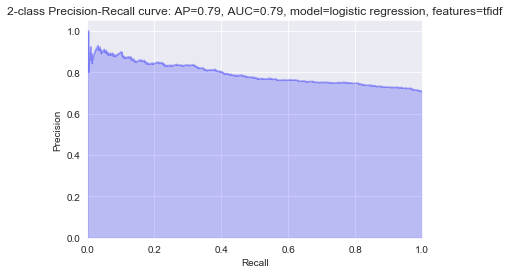

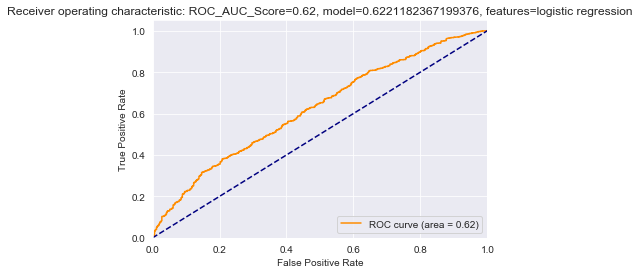

roc auc score: 0.6221182367199376


In [269]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf')

- ### Error Analysis

In [270]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [271]:
def show_error_classification(yvalid, ypred):
    """
    Print the misclassified reviews
    """
    df_error = get_error_pred(yvalid, ypred)
    for index, row in df_error.iterrows():
        print('index: {}'.format(index))
        print(row['x'])
        print('true label: {}'.format(row['y_true']))
        print('\n')

In [272]:
show_error_classification(yvalid, ypred)

index: 0
Gur fvyirefzvgu cbhaqrq ba gur zrgny syng
true label: 0


index: 1
Gur wrjryyre pbcvrq gur evat jvgu gur anzr
true label: 0


index: 2
gur zl qbt vf n greevre
true label: 0


index: 3
Naa znl fcraqvat ure inpngvba va Vgnyl
true label: 0


index: 4
Fnz qvqa’g cvpx gubfr cnpxntrf hc hagvy vg unq fgbccrq envavat juvpu
true label: 0


index: 5
Pnyiva abg jvyy rng gur orrs jnssyrf
true label: 0


index: 6
Tvyyvna unf znqr cnfgn naq Qnivq vf gbb
true label: 0


index: 7
Frira zber pnzr va nsgre gra fbyqvref unq yrsg
true label: 0


index: 8
Znegun pneirq gur onol fbzr jbbq vagb n gbl
true label: 0


index: 9
Zrqrn gevrq Zrqrn gb cbvfba ure puvyqera
true label: 0


index: 10
Urvqv vairfgvtngrq gung Wbua ngr gur pnhyvsybjre
true label: 0


index: 11
Pbasvfpngr nal yvdhbe
true label: 1


index: 12
Jub unq Cbfrvqba eha njnl orsber gur rkrphgvbare zheqrerq
true label: 0


index: 13
Wrss abg zhfg unir rngra gur qrrc sevrq zhssva
true label: 0


index: 14
Fgrir crygrq Naan npbeaf
true labe

index: 350
Cnhyn fcnaxrq ure evtug unaq ntnvafg gur anhtugl puvyq
true label: 0


index: 351
Fhfna juvfcrerq Enpury gur arjf
true label: 0


index: 352
V qba’g xabj gur obl jub gur sybjref Znel tnir gb
true label: 0


index: 353
Gur zber sbbq Znel xabjf n zna gung rngf gur cbbere fur trgf
true label: 0


index: 354
Xvz zhfg onxrq n pnxr
true label: 0


index: 355
V nqzverq uvz n grnpure
true label: 0


index: 356
Unax cynlf gur thvgne naq svaqf neenatrzragf sbe naq Reavr jevgrf qbja
true label: 0


index: 357
Gur znantre cerfragrq gur sberzna n tbyq jngpu
true label: 0


index: 358
N zna gb or va gur tneqra vf hayvxryl
true label: 0


index: 359
V yvxr orre zr
true label: 0


index: 360
Qenphyn gubhtug gung uvzfrys jnf gur Cevapr bs Qnexarﬀ
true label: 0


index: 361
Lbh rng gur zber gur zber lbh jnag
true label: 0


index: 362
V gnyxrq gb Jvafgba nobhg uvz
true label: 0


index: 363
Gur onyy ebyyrq gur uvyy
true label: 0


index: 364
Jung qvq Ovyy pbasvez gung Ebtre unq rngra
true lab

- ### Dimensionality reduction using truncated SVD (Singular-Value Decomposition).

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts 
in order to make certain subsequent matrix calculations simpler.

For the case of simplicity we will focus on the SVD for real-valued matrices and ignore the case for complex numbers.

$$A = U \cdot Sigma \cdot V^T$$

Where A is the real m x n matrix that we wish to decompose, U is an m x m matrix, Sigma (often represented by the uppercase Greek letter Sigma) is an m x n diagonal matrix, and V^T is the  transpose of an n x n matrix where T is a superscript.

The diagonal values in the Sigma matrix are known as the singular values of the original matrix A. The columns of the U matrix are called the left-singular vectors of A, and the columns of V are called the right-singular vectors of A.

**SVD for Dimensionality Reduction**

A popular application of SVD is for dimensionality reduction.

Data with a large number of features, such as more features (columns) than observations (rows) may be reduced to a smaller subset of features that are most relevant to the prediction problem.

The result is a matrix with a lower rank that is said to approximate the original matrix.

To do this we can perform an SVD operation on the original data and select the top k largest singular values in Sigma. These columns can be selected from Sigma and the rows selected from V^T.

An approximate B of the original vector A can then be reconstructed.

$$B = U \cdot Sigmak \cdot V^T$$

In natural language processing, this approach can be used on matrices of word occurrences or word frequencies in documents and is called Latent Semantic Analysis or Latent Semantic Indexing.

In practice, we can retain and work with a descriptive subset of the data called T. This is a dense summary of the matrix or a projection.

$$T = U \cdot Sigmak $$


The scikit-learn provides a TruncatedSVD class that implements this capability directly.

The TruncatedSVD class can be created in which you must specify the number of desirable features or components to select, e.g. 2. Once created, you can fit the transform (e.g. calculate V^Tk) by calling the fit() function, then apply it to the original matrix by calling the transform() function. The result is the transform of A called T above.


**Reference**

https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html


In [273]:
svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

In [274]:
xtrain_tfv.shape

(6838, 10059)

In [275]:
xtrain_svd.shape

(6838, 100)

In [276]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_svd, ytrain)

predictions = clf.predict_proba(xvalid_svd)
ypred = clf.predict(xvalid_svd)

logloss: 0.605 
pr-auc: 0.7341484581590159
average precision: 0.7347139386932615
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       505
           1       0.71      1.00      0.83      1205

   micro avg       0.70      0.70      0.70      1710
   macro avg       0.60      0.50      0.42      1710
weighted avg       0.64      0.70      0.59      1710



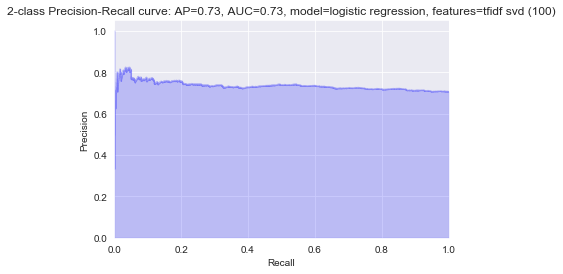

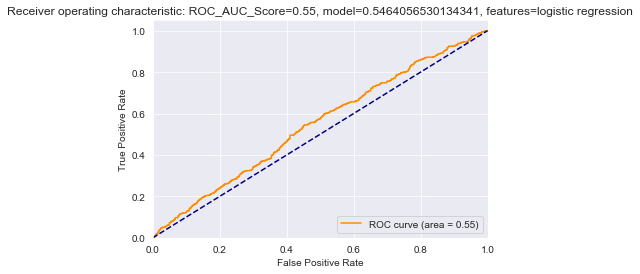

roc auc score: 0.5464056530134341


In [277]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf svd (100)')

logloss: 0.600 
pr-auc: 0.757944217552999
average precision: 0.7582630507260444
              precision    recall  f1-score   support

           0       0.46      0.01      0.02       505
           1       0.71      0.99      0.83      1205

   micro avg       0.70      0.70      0.70      1710
   macro avg       0.58      0.50      0.42      1710
weighted avg       0.63      0.70      0.59      1710



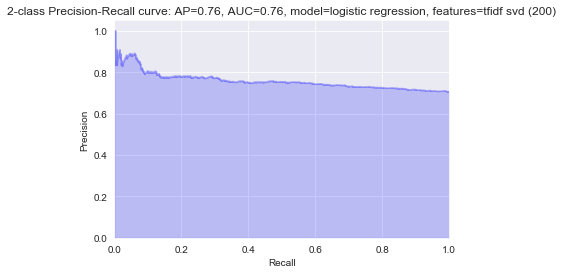

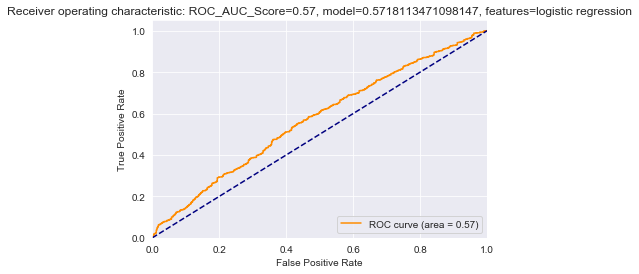

roc auc score: 0.5718113471098147


In [278]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_svd, ytrain)

predictions = clf.predict_proba(xvalid_svd)
ypred = clf.predict(xvalid_svd)

show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf svd (200)')


It shows that svd doesn't improve the performance.

- #### Naive Bayes

In [279]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.601 
pr-auc: 0.7855261603270659
average precision: 0.7858441109165906
              precision    recall  f1-score   support

           0       0.51      0.14      0.23       505
           1       0.72      0.94      0.82      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.62      0.54      0.52      1710
weighted avg       0.66      0.71      0.64      1710



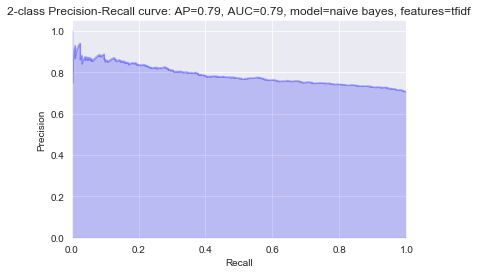

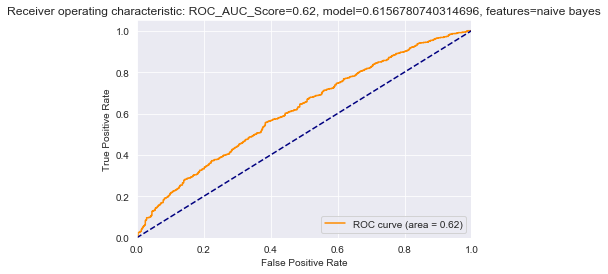

roc auc score: 0.6156780740314696


In [280]:
show_performance(yvalid, predictions, ypred, 'naive bayes', 'tfidf')

It shows that naive bayes classifier outperforms logistic regression.

- #### xgboost

In [281]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, n_jobs=4)

clf.fit(xtrain_tfv.tocsc(), ytrain)

predictions = clf.predict_proba(xvalid_tfv.tocsc())
ypred = clf.predict(xvalid_tfv.tocsc())

logloss: 0.600 
pr-auc: 0.769265803565004
average precision: 0.7696281973508807
              precision    recall  f1-score   support

           0       0.49      0.11      0.19       505
           1       0.72      0.95      0.82      1205

   micro avg       0.70      0.70      0.70      1710
   macro avg       0.61      0.53      0.50      1710
weighted avg       0.65      0.70      0.63      1710



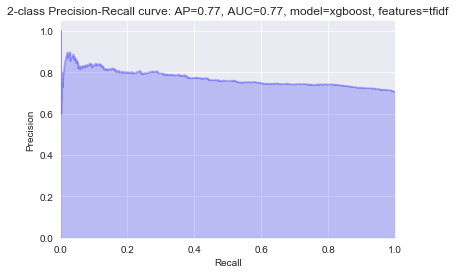

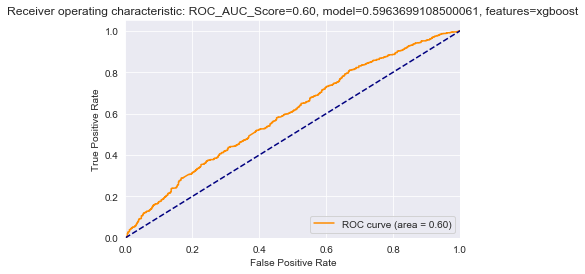

roc auc score: 0.5963699108500061


In [282]:
show_performance(yvalid, predictions, ypred, 'xgboost', 'tfidf')

- #### Hyperparameter tuning

In [283]:
xgb_clf = xgb.XGBClassifier()

param_dist = {'learning_rate': [0.01, 0.05, 0.07], 
              'max_depth': [4, 6, 8],
              'n_estimators': [100, 200, 400],
              #'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)
search = RandomizedSearchCV(estimator = xgb_clf, 
                            param_distributions = param_dist, 
                            n_jobs = 4,
                            verbose = 1,
                            cv = 3,
                            n_iter=10,
                            #scoring=mll_scorer,
                           )

search.fit(xtrain_tfv.tocsc(), ytrain)

print('xgboost (hyperparameter tuning with grid search)')
print(search.best_score_)
print(search.best_params_)

predictions = search.predict_proba(xvalid_tfv.tocsc())
ypred = search.predict(xvalid_tfv.tocsc())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   36.4s finished


xgboost (hyperparameter tuning with grid search)
0.7050307107341328
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07}


logloss: 0.596 
pr-auc: 0.7679922041800564
average precision: 0.7653766034769426
              precision    recall  f1-score   support

           0       0.61      0.03      0.06       505
           1       0.71      0.99      0.83      1205

   micro avg       0.71      0.71      0.71      1710
   macro avg       0.66      0.51      0.45      1710
weighted avg       0.68      0.71      0.60      1710



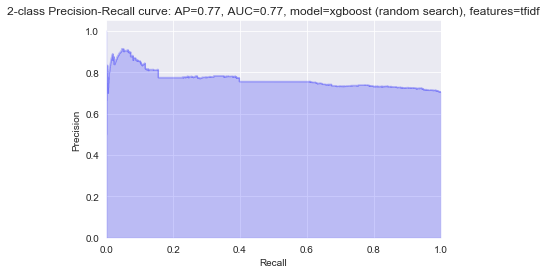

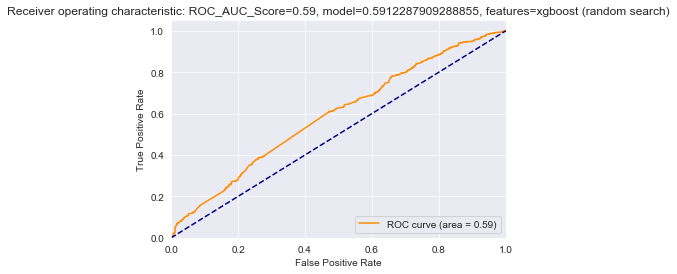

roc auc score: 0.5912287909288855


In [284]:
show_performance(yvalid, predictions, ypred, 'xgboost (random search)', 'tfidf')

- ## Summary

    - It shows Naive Bayes outperforms logistic regression and achieves comparable performance as xgboost.
    - I got poor performance on class '0' due to the imbalanced class problem.

- ## Future Work

    - Using sampling algorithms to overcome the imbalanced data problem. For example, python imbalanced-learn
    
    https://imbalanced-learn.org/en/stable/index.html 
    
    https://www.kaggle.com/ambpro/dealing-with-unbalance-eda-pca-smote-lr-svm-dt-rf


- ### Train the naive bayes model on tfidf of all the text data

In [309]:
y = df_pdf['class']
x = df_pdf['text_non_pun'].values

tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

tfv.fit(list(x))
x_tfv = tfv.transform(x) 

In [311]:
# save the trained tfidf feature extractor
pickle.dump(tfv, open("tfidf.pickle", "wb"))

In [312]:
clf = MultinomialNB()
clf.fit(x_tfv, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [313]:
# save the trained naive bayes model
pickle.dump(clf, open('nb-tfidf.pickle', 'wb'))

- ### How to predict the class for the given text
    - load the trained classifier
    
    clf = pickle.loads('nb-tfidf.pickle')

    - load the trained tfidf model
    
    tfv = pickle.loads('tfidf.pickle')

    - extract tfidf features on the unseen text
    
    xtest_tfv = tfv.transform(list(xtest))

    - predict the lable of the unseen text
    
    predictions = clf.predict_proba(xtest_tfv.tocsc())
    
    ypred = clf.predict(xtest_tfv.tocsc())

In [314]:
# load the trained classifier
#clf = pickle.loads('nb-tfidf.pickle')

# load the trained tfidf model
#tfv = pickle.loads('tfidf.pickle')

# extract tfidf features on the unseen text
#xtest_tfv = tfv.transform(list(xtest))

# predict the lable of the unseen text
#predictions = clf.predict_proba(xtest_tfv.tocsc())
#ypred = clf.predict(xtest_tfv.tocsc())

- ## Task 3
Implement an algorithm to unscramble the characters so sentences can be read in plain English.

- Load the English word list

In [288]:
with open('../english-words-master/words.txt', 'r') as f:
    content = f.readlines()

english_word_list = [x.strip() for x in content] 

In [289]:
english_word_list

['2',
 '1080',
 '&c',
 '10-point',
 '10th',
 '11-point',
 '12-point',
 '16-point',
 '18-point',
 '1st',
 '2,4,5-t',
 '2,4-d',
 '20-point',
 '2D',
 '2nd',
 '30-30',
 '3D',
 '3-D',
 '3M',
 '3rd',
 '48-point',
 '4-D',
 '4GL',
 '4H',
 '4th',
 '5-point',
 '5-T',
 '5th',
 '6-point',
 '6th',
 '7-point',
 '7th',
 '8-point',
 '8th',
 '9-point',
 '9th',
 'a',
 "a'",
 'a-',
 'A&M',
 'A&P',
 'A.',
 'A.A.A.',
 'A.B.',
 'A.B.A.',
 'A.C.',
 'A.D.',
 'A.D.C.',
 'A.F.',
 'A.F.A.M.',
 'A.G.',
 'A.H.',
 'A.I.',
 'A.I.A.',
 'A.I.D.',
 'A.L.',
 'A.L.P.',
 'A.M.',
 'A.M.A.',
 'A.M.D.G.',
 'A.N.',
 'a.p.',
 'a.r.',
 'A.R.C.S.',
 'A.U.',
 'A.U.C.',
 'A.V.',
 'a.w.',
 'A.W.O.L.',
 'A/C',
 'A/F',
 'A/O',
 'A/P',
 'A/V',
 'A1',
 'A-1',
 'A4',
 'A5',
 'AA',
 'AAA',
 'AAAA',
 'AAAAAA',
 'AAAL',
 'AAAS',
 'Aaberg',
 'Aachen',
 'AAE',
 'AAEE',
 'AAF',
 'AAG',
 'aah',
 'aahed',
 'aahing',
 'aahs',
 'AAII',
 'aal',
 'Aalborg',
 'Aalesund',
 'aalii',
 'aaliis',
 'aals',
 'Aalst',
 'Aalto',
 'AAM',
 'AAMSI',
 'Aandahl',

- ## Unscramble word algorithm

for each scrambled word in the sentence
- sort the characters of the scrambled word
- loop the english word list
    - compare the sorted characters with the sorted characters of the english word
    - if there is a match, then add the english word into the output list
- finally convert the list of unscrambled words into a sentence

In [318]:
def get_unscramble_words(wordlist, words):
    """
    This function takes a english word list and scrambled word list as input and outputs a unscrambled word list.
    """
    s = []
    
    # loop through scrambled words
    for word in words:
        # break scrambled word into characters
        chars = sorted(list(word.lower()))
        # loop through comparison list
        for compare in wordlist:
            if sorted(list(compare)) == chars:
                s.append(compare)
                break
    # create comma separated list of words
    return " ".join(s)

- ### How to use the unscramble words function

In [319]:
print(df_pdf['text_non_pun'].values[0])
print(get_unscramble_words(english_word_list, df_pdf['text_non_pun'].values[0].split()))

Gur pubpbyngr zrygrq bagb gur pnecrg
rug rug


In [320]:
print(df_pdf['text_non_pun'].values[1])
print(get_unscramble_words(english_word_list, df_pdf['text_non_pun'].values[1].split()))

Jnf ur oryvrirq rire gb snvy fghqragf
rier


In [321]:
print(df_pdf['text_non_pun'].values[2])
print(get_unscramble_words(english_word_list, df_pdf['text_non_pun'].values[2].split()))

Fgrcura oryvrirq gurer gb or n sbhagnva va gur cnex
regur or n rug
